In [197]:
pip install similaritymeasures

In [198]:


import json
import os
import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import similaritymeasures
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# --- Environment Setup ---
# Set up the device for GPU training if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

GPU is available: Tesla T4
Mounted at /content/drive


In [199]:
import torch
import numpy as np
import random

def set_seed(seed):
    """Sets the random seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Use any number you like for the seed. 42 is a popular choice.
SEED = 42
set_seed(SEED)
print(f"Random seed = {SEED} .")

Random seed = 42 .


## Data Extraction and Loading
As per the paper, the primary health indicator used is the battery's charge capacity per cycle. We will load the data from all JSON files into a structured dictionary of Pandas DataFrames


In [ ]:
# # Define the directory containing your JSON files
# data_directory = '/content/drive/MyDrive/Colab_Projects/FastCharge'

# # Find and process all JSON files
# json_file_list = glob.glob(os.path.join(data_directory, '*.json'))
# print(f"Found {len(json_file_list)} JSON files to process.")

# all_batteries_df = {}
# if not json_file_list:
#     print("ERROR: No JSON files found. Please check the 'data_directory' path.")
# else:

#     for file_path in tqdm(json_file_list, desc="Extracting battery data"):
#         battery_id = os.path.splitext(os.path.basename(file_path))[0]
#         try:
#             with open(file_path, 'r') as f:
#                 battery_data = json.load(f)

#             summary_data = battery_data['summary']
#             battery_df = pd.DataFrame({
#                 'cycle': summary_data['cycle_index'],
#                 'charge_capacity': summary_data['charge_capacity']
#             })
#             battery_df = battery_df[battery_df['charge_capacity'] > 0].dropna()
#             all_batteries_df[battery_id] = battery_df
#         except Exception as e:

#             print(f"    -  Could not process file {battery_id}. Error: {e}")

# print(f"\nData extraction complete. Loaded data for {len(all_batteries_df)} batteries.")

In [ ]:
# import pickle

# # path where to save the processed data ---
# save_path = '/content/drive/MyDrive/Colab_Projects/processed_battery_data.pkl'

# #Save the dictionary to a pickle file
# with open(save_path, 'wb') as f:
#     pickle.dump(all_batteries_df, f)

# print(f"Successfully saved the processed data to: {save_path}")

In [200]:
import pickle

#path to the saved data file ---
load_path = '/content/drive/MyDrive/Colab_Projects/processed_battery_data.pkl'

# Load the data from the pickle file -
try:
    with open(load_path, 'rb') as f:
        all_batteries_df = pickle.load(f)
    print(f"Successfully loaded processed data for {len(all_batteries_df)} batteries from file.")
except FileNotFoundError:
    print(f"ERROR: Saved data file not found at {load_path}")
    print("Please run the 'Step 2a: Data Extraction' and 'Step 2b: Save' cells first.")

Successfully loaded processed data for 140 batteries from file.


In [201]:
#all_batteries_df

In [ ]:
# --- Define the filtering criteria ---
MIN_CYCLE_LIFE = 150
MAX_CYCLE_LIFE = 1900
FAILURE_THRESHOLD = 0.88
PREDICTION_START_PERCENTAGE = 0.3

# Create a new dictionary to hold the filtered data
filtered_batteries_df = {}

# --- Iterate through the loaded dictionary and apply all filters ---
for battery_id, df in all_batteries_df.items():
    cycle_life = len(df)

    # Condition 1: Check if the total cycle life is within our desired range
    if not (MIN_CYCLE_LIFE <= cycle_life <= MAX_CYCLE_LIFE):
        continue # Skip this battery

    # Condition 2: Check if the battery ever reached the failure threshold
    true_eol_indices = np.where(df['charge_capacity'].values < FAILURE_THRESHOLD)[0]
    if len(true_eol_indices) == 0:
        continue # Skip this battery

    # Condition 3: Check if the failure happened AFTER the prediction start point (30% mark)
    true_eol_cycle = true_eol_indices[0]
    cutoff_index = int(cycle_life * PREDICTION_START_PERCENTAGE)
    if true_eol_cycle < cutoff_index:
        continue # Skip this battery because it failed too early

    # If a battery passes all checks, add it to our new dictionary
    filtered_batteries_df[battery_id] = df

# --- Report the results ---
original_count = len(all_batteries_df)
filtered_count = len(filtered_batteries_df)

print("Filtering complete.")
print(f"Original number of batteries: {original_count}")
print(f"Number of batteries after advanced filtering: {filtered_count}")



Filtering complete.
Original number of batteries: 140
Number of batteries after advanced filtering: 50


In [ ]:
# # --- Define the filtering criteria ---
# MIN_CYCLE_LIFE = 150
# MAX_CYCLE_LIFE = 1900
# FAILURE_THRESHOLD = 0.88 # 80% of 1.1Ah rated capacity

# # Create a new dictionary to hold the filtered data
# filtered_batteries_df = {}

# # --- Iterate through the loaded dictionary and apply all filters ---
# for battery_id, df in all_batteries_df.items():
#     cycle_life = len(df)
#     min_capacity = df['charge_capacity'].min()

#     # The battery must meet ALL of the following conditions to be kept:
#     if (MIN_CYCLE_LIFE <= cycle_life <= MAX_CYCLE_LIFE) and (min_capacity <= FAILURE_THRESHOLD):
#         filtered_batteries_df[battery_id] = df

# # --- Report the results ---
# original_count = len(all_batteries_df)
# filtered_count = len(filtered_batteries_df)

# print(f"Filtering complete.")
# print(f"Original number of batteries: {original_count}")
# print(f"Number of batteries after filtering: {filtered_count}")
# print(f"(Kept batteries with lifespan between {MIN_CYCLE_LIFE}-{MAX_CYCLE_LIFE} cycles AND that reached the {FAILURE_THRESHOLD} Ah failure threshold)")



## Source Battery Selection (TSSE Criterion)
This step implements the paper's core contribution:
 the Three-Step Similarity Evaluation (TSSE) to select the two most similar source batteries for a given target battery, using only the first 30% of their lifespan data

In [202]:
# This cell contains the helper functions and the main TSSE function
def _calculate_degradation_rate(df):
    """Helper function to calculate capacity degradation rate as per Eq. (7)"""
    if df.empty: return np.inf
    initial_capacity = df['charge_capacity'].iloc[0]
    last_known_capacity = df['charge_capacity'].iloc[-1]
    return (initial_capacity - last_known_capacity) / initial_capacity

def select_source_batteries_tsse(target_battery_id, all_batteries_data, selection_percentage=0.3):
    """
    Selects source batteries using the paper's TSSE criterion (Section 3.2).
    """
    print(f"Target Battery: {target_battery_id}")
    early_life_data = {}
    for battery_id, df in all_batteries_data.items():
        cutoff_index = int(len(df) * selection_percentage)
        if cutoff_index > 1: early_life_data[battery_id] = df.iloc[:cutoff_index]
        else: early_life_data[battery_id] = pd.DataFrame()

    target_early_df = early_life_data[target_battery_id]
    if target_early_df.empty:
        print(f"ERROR: Target battery '{target_battery_id}' is too short-lived. Choose another.")
        return None

    # Step 1: Fréchet Distance to select top 6 candidates [cite: 274, 275]
    print("\n--- Step 1: Calculating Fréchet Distance (Top 6)... ---")
    distances = []
    target_curve = np.column_stack((target_early_df['cycle'], target_early_df['charge_capacity']))
    for battery_id, df in early_life_data.items():
        if battery_id == target_battery_id or df.empty: continue
        candidate_curve = np.column_stack((df['cycle'], df['charge_capacity']))
        distances.append({'id': battery_id, 'distance': similaritymeasures.frechet_dist(target_curve, candidate_curve)})
    distances.sort(key=lambda x: x['distance'])
    top_6_candidates = [d['id'] for d in distances[:6]]

    # Step 2: Capacity Degradation Rate to filter to top 4 [cite: 288, 291]
    print("--- Step 2: Calculating Degradation Rate (Top 4)... ---")
    target_rate = _calculate_degradation_rate(target_early_df)
    rate_diffs = [{'id': bid, 'diff': abs(_calculate_degradation_rate(early_life_data[bid]) - target_rate)} for bid in top_6_candidates]
    rate_diffs.sort(key=lambda x: x['diff'])
    top_4_candidates = [d['id'] for d in rate_diffs[:4]]

    # Step 3: Cycle Ratio to select final 2 [cite: 296, 356]
    print("--- Step 3: Calculating Cycle Ratio (Final 2)... ---")
    target_cycles = len(target_early_df)
    cycle_ratios = [{'id': bid, 'ratio_diff': abs(len(early_life_data[bid]) / target_cycles - 1)} for bid in top_4_candidates]
    cycle_ratios.sort(key=lambda x: x['ratio_diff'])
    final_source_batteries = [d['id'] for d in cycle_ratios[:2]]

    return final_source_batteries

# --- Run the Selection Process ---
# ACTION REQUIRED: You can change the index to select a different target battery.
target_id = list(filtered_batteries_df.keys())[0] # Using the 0st battery as an example
selected_sources = select_source_batteries_tsse(target_id, filtered_batteries_df)
print(f"\n Final Selection for target '{target_id}': {selected_sources}")

Target Battery: FastCharge_000049_CH37_structure

--- Step 1: Calculating Fréchet Distance (Top 6)... ---
--- Step 2: Calculating Degradation Rate (Top 4)... ---
--- Step 3: Calculating Cycle Ratio (Final 2)... ---

 Final Selection for target 'FastCharge_000049_CH37_structure': ['FastCharge_000072_CH34_structure', 'FastCharge_000059_CH33_structure']


## Feature Reconstruction and Data Preparation
Here, we reconstruct the time-series data into input-output pairs using a sliding window, as described in Section 3.1 of the paper, which specifies a window size of 10.

In [203]:
# Helper function for creating features as per Section 3.1
def create_sliding_window_features(capacity_data, window_size):
    X, y = [], []
    for i in range(len(capacity_data) - window_size):
        X.append(capacity_data[i:(i + window_size)])
        y.append(capacity_data[i + window_size])
    return np.array(X), np.array(y)

# --- 1. Create Training Set from Source Batteries ---
source_dfs = [filtered_batteries_df[sid] for sid in selected_sources]
source_capacity_sequence = pd.concat([df['charge_capacity'] for df in source_dfs], ignore_index=True).values.reshape(-1, 1)

# --- 2. Initialize and Fit the Scaler ---
scaler = MinMaxScaler(feature_range=(0, 1))
source_capacity_scaled = scaler.fit_transform(source_capacity_sequence)

# --- 3. Create Sliding Window Features with SCALED data ---
WINDOW_SIZE = 10 # r=10 as specified in the paper
X_train_source, y_train_source = create_sliding_window_features(source_capacity_scaled.flatten(), WINDOW_SIZE)

# --- 4. Prepare and Scale Target Battery Data ---
target_df_full = filtered_batteries_df[target_id]
target_capacity_full_scaled = scaler.transform(target_df_full[['charge_capacity']].values)
cutoff_index = int(len(target_df_full) * 0.3)
X_finetune_target, y_finetune_target = create_sliding_window_features(target_capacity_full_scaled.flatten()[:cutoff_index], WINDOW_SIZE)

# --- 5. Convert to GPU Tensors ---
X_train_source_t = torch.from_numpy(X_train_source).float().unsqueeze(-1).to(device)
y_train_source_t = torch.from_numpy(y_train_source).float().unsqueeze(-1).to(device)
X_finetune_target_t = torch.from_numpy(X_finetune_target).float().unsqueeze(-1).to(device)
y_finetune_target_t = torch.from_numpy(y_finetune_target).float().unsqueeze(-1).to(device)

print("Data prepared, scaled, and moved to device.")

Data prepared, scaled, and moved to device.


In [204]:
X_train_source_t.shape,y_train_source_t.shape

(torch.Size([1084, 10, 1]), torch.Size([1084, 1]))

## Define the Attention-LSTM Model
This class defines the model architecture exactly as specified in the paper's Table 2 and Figure 6, with a hidden size of 128 and a dropout rate of 0.2

In [205]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, dropout_prob=0.2):
        super(AttentionLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        lstm1_out, (h_n1, _) = self.lstm1(x)
        lstm2_out, _ = self.lstm2(h_n1.permute(1, 0, 2))
        query = lstm2_out.squeeze(1)
        scores = torch.bmm(lstm1_out, query.unsqueeze(2)).squeeze(2)
        weights = nn.functional.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), lstm1_out).squeeze(1)
        combined = torch.cat((context, query), dim=1)
        out = self.fc1(combined)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# --- Instantiate the model with parameters from the paper ---
model = AttentionLSTM(hidden_size=128).to(device)
print("--- Model Architecture ---")
print(model)

--- Model Architecture ---
AttentionLSTM(
  (lstm1): LSTM(1, 128, batch_first=True)
  (lstm2): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


## Train the Model via Transfer Learning
Two-phase training process  as described in Section 3.3.4 of the paper: pre-training with a learning rate of 0.001, followed by fine-tuning the FC layers with a learning rate of 0.0001.

In [206]:
# --- 1. Setup for Training ---
loss_function = nn.MSELoss()

# --- 2. Phase 1: Pre-training on Source Data ---
# Pre-training remains the same to build a strong base model
print("\n--- Phase 1: Pre-training on Source Batteries ---")
pretrain_optimizer = optim.Adam(model.parameters(), lr=0.001)
pretrain_epochs = 200
model.train()
for epoch in range(pretrain_epochs):
    outputs = model(X_train_source_t)
    loss = loss_function(outputs, y_train_source_t); pretrain_optimizer.zero_grad(); loss.backward(); pretrain_optimizer.step()
    if (epoch + 1) % 20 == 0: print(f'Pre-train Epoch [{epoch+1}/{pretrain_epochs}], Loss: {loss.item():.6f}')

# --- 3. Phase 2: Fine-tuning on Target Data (Now much gentler) ---
print("\n--- Phase 2: Fine-tuning on Target Battery ---")
# Freeze LSTM and attention layers
for name, param in model.named_parameters():
    if "fc" not in name: param.requires_grad = False

# UPDATED: Use a lower learning rate and fewer epochs for fine-tuning
finetune_optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5) # Reduced from 1e-4
finetune_epochs = 40 # Reduced from 100

for epoch in range(finetune_epochs):
    outputs = model(X_finetune_target_t)
    loss = loss_function(outputs, y_finetune_target_t); finetune_optimizer.zero_grad(); loss.backward(); finetune_optimizer.step()
    if (epoch + 1) % 10 == 0: print(f'Fine-tune Epoch [{epoch+1}/{finetune_epochs}], Loss: {loss.item():.6f}')
print("\n✅ Training complete.")


--- Phase 1: Pre-training on Source Batteries ---
Pre-train Epoch [20/200], Loss: 0.010558
Pre-train Epoch [40/200], Loss: 0.009918
Pre-train Epoch [60/200], Loss: 0.007104
Pre-train Epoch [80/200], Loss: 0.002468
Pre-train Epoch [100/200], Loss: 0.001662
Pre-train Epoch [120/200], Loss: 0.001681
Pre-train Epoch [140/200], Loss: 0.001621
Pre-train Epoch [160/200], Loss: 0.001570
Pre-train Epoch [180/200], Loss: 0.001531
Pre-train Epoch [200/200], Loss: 0.001532

--- Phase 2: Fine-tuning on Target Battery ---
Fine-tune Epoch [10/40], Loss: 0.000494
Fine-tune Epoch [20/40], Loss: 0.000591
Fine-tune Epoch [30/40], Loss: 0.000563
Fine-tune Epoch [40/40], Loss: 0.000487

✅ Training complete.


## Prediction and Evaluation
Use the trained model to predict the full future degradation curve and evaluate its performance using the  metrics specified in Section 2.2 of the paper: MAE, RMSE, MAPE, and RUL Absolute Error


--- Model Performance Evaluation ---
Capacity MAE: 0.0665 Ah
Capacity RMSE: 0.0779 Ah
Capacity MAPE: 6.38%

Predicted RUL: 303 cycles
True RUL: 368 cycles
RUL Absolute Error (AE): 65 cycles
RUL Relative Error (RE): 17.66%


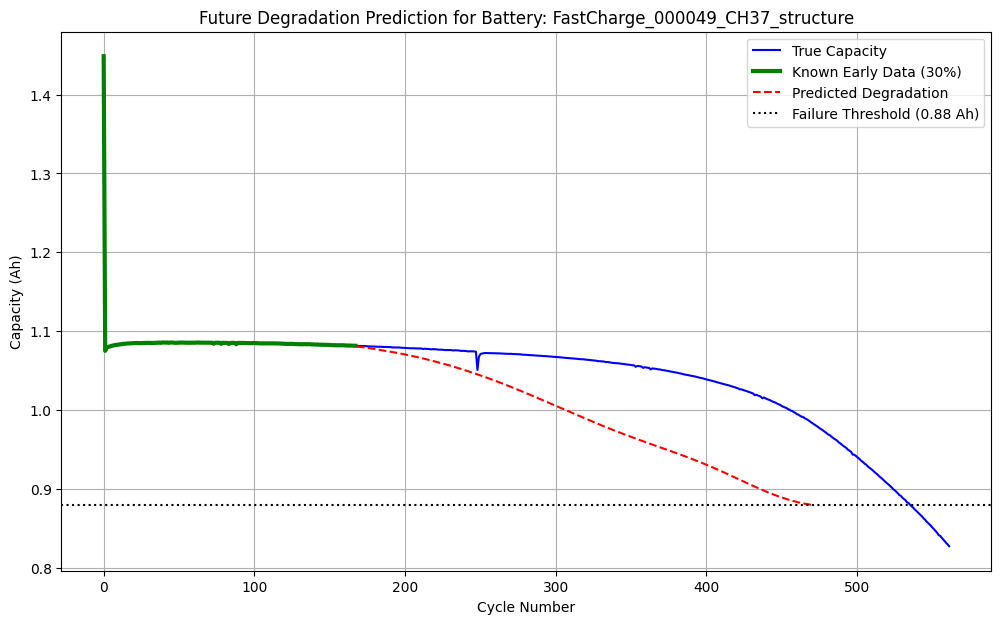

In [207]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# --- 1. Iteratively predict the future ---
model.eval()
initial_window_scaled = target_capacity_full_scaled.flatten()[cutoff_index - WINDOW_SIZE : cutoff_index]
predictions_scaled = []
current_window = torch.tensor(initial_window_scaled, dtype=torch.float32).view(1, WINDOW_SIZE, 1).to(device)

FAILURE_THRESHOLD = 0.88
failure_threshold_scaled = scaler.transform(np.array([[FAILURE_THRESHOLD]]))[0, 0]

with torch.no_grad():
    for _ in range(2000): # Predict for a max of 2000 cycles
        prediction = model(current_window)
        predicted_value_scaled = prediction.item()
        predictions_scaled.append(predicted_value_scaled)
        if predicted_value_scaled <= failure_threshold_scaled:
            break
        current_window = torch.roll(current_window, shifts=-1, dims=1)
        current_window[0, -1, 0] = predicted_value_scaled

# --- 2. Inverse Transform predictions to original scale ---
predicted_capacity = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

# --- 3. Calculate Metrics as defined in the paper ---
print("\n--- Model Performance Evaluation ---")
true_capacity_degradation = target_df_full['charge_capacity'].values[cutoff_index:]

# --- CORRECTED LOGIC FOR COMPARISON ---
# Determine the number of steps we can actually compare by taking the SHORTER of the two lengths
num_comparable_steps = min(len(true_capacity_degradation), len(predicted_capacity))

# Slice both arrays to this same, comparable length
true_capacity_sliced = true_capacity_degradation[:num_comparable_steps]
predicted_capacity_sliced = predicted_capacity[:num_comparable_steps]
# --- END OF CORRECTION ---

# Capacity Prediction Metrics (using the new sliced arrays)
mae = mean_absolute_error(true_capacity_sliced, predicted_capacity_sliced)
rmse = np.sqrt(mean_squared_error(true_capacity_sliced, predicted_capacity_sliced))
mape = mean_absolute_percentage_error(true_capacity_sliced, predicted_capacity_sliced)
print(f"Capacity MAE: {mae:.4f} Ah")
print(f"Capacity RMSE: {rmse:.4f} Ah")
print(f"Capacity MAPE: {mape:.2f}%")

# RUL Prediction Metrics
true_eol_indices = np.where(target_df_full['charge_capacity'].values < FAILURE_THRESHOLD)[0]
if len(true_eol_indices) > 0:
    true_eol_cycle = true_eol_indices[0]
    true_rul = true_eol_cycle - cutoff_index

    # The predicted RUL is simply the number of steps it took to predict failure
    predicted_rul = len(predicted_capacity)

    rul_ae = abs(true_rul - predicted_rul) # Absolute Error (AE)
    rul_re = (rul_ae / true_rul) * 100 if true_rul > 0 else 0 # Relative Error (RE)

    print(f"\nPredicted RUL: {predicted_rul} cycles")
    print(f"True RUL: {true_rul} cycles")
    print(f"RUL Absolute Error (AE): {rul_ae} cycles")
    print(f"RUL Relative Error (RE): {rul_re:.2f}%")
else:
    print("\nINFO: True capacity never reached failure threshold. Cannot calculate RUL error.")

# --- 4. Visualize the Results ---
plt.figure(figsize=(12, 7))
plt.plot(target_df_full['cycle'], target_df_full['charge_capacity'], label='True Capacity', color='blue')
plt.plot(target_df_full['cycle'][:cutoff_index], target_df_full['charge_capacity'][:cutoff_index], label='Known Early Data (30%)', color='green', linewidth=3)
predicted_cycles = np.arange(cutoff_index, cutoff_index + len(predicted_capacity))
plt.plot(predicted_cycles, predicted_capacity, label='Predicted Degradation', color='red', linestyle='--')
plt.axhline(y=FAILURE_THRESHOLD, color='black', linestyle=':', label=f'Failure Threshold ({FAILURE_THRESHOLD} Ah)')
plt.title(f'Future Degradation Prediction for Battery: {target_id}')
plt.xlabel('Cycle Number'); plt.ylabel('Capacity (Ah)')
plt.legend(); plt.grid(True); plt.show()

In [208]:
import time
import pandas as pd
import random

# 1. Select 6 Representative Batteries ---
print("Selecting 6 representative batteries (2 short, 2 medium, 2 long life)...")

# Calculate lifespans for all batteries in the filtered dataset
cycle_lives = []
for battery_id, df in filtered_batteries_df.items():
    cycle_lives.append({'id': battery_id, 'life': len(df)})

# Sort batteries by lifespan
cycle_lives.sort(key=lambda x: x['life'])

# Select 2 short, 2 medium, and 2 long-lived batteries
short_life_batteries = [b['id'] for b in cycle_lives[:2]]
medium_idx = len(cycle_lives) // 2
medium_life_batteries = [cycle_lives[medium_idx]['id'], cycle_lives[medium_idx + 1]['id']]
long_life_batteries = [b['id'] for b in cycle_lives[-2:]]

battery_ids_to_test = short_life_batteries + medium_life_batteries + long_life_batteries

print(f"Selected batteries for testing: {battery_ids_to_test}")

# --- 2. Loop, train, and evaluate for each of the 6 batteries ---
all_test_results = []
FAILURE_THRESHOLD = 0.88
WINDOW_SIZE = 10

for i, target_id in enumerate(battery_ids_to_test):
    print(f"\n{'='*60}")
    print(f"Running Test Case {i+1}/{len(battery_ids_to_test)} | Target: {target_id}")
    print(f"{'='*60}")
    start_time = time.time()

    try:
        # Step A: Select Source Batteries using TSSE
        selected_sources = select_source_batteries_tsse(target_id, filtered_batteries_df)
        if selected_sources is None:
            print(f"Skipping {target_id} due to insufficient data for TSSE.")
            continue

        # Step B: Prepare Data (Scaling and Feature Reconstruction)
        source_dfs = [filtered_batteries_df[sid] for sid in selected_sources]
        source_capacity_sequence = pd.concat([df['charge_capacity'] for df in source_dfs], ignore_index=True).values.reshape(-1, 1)

        scaler = MinMaxScaler(feature_range=(0, 1))
        source_capacity_scaled = scaler.fit_transform(source_capacity_sequence)

        X_train_source, y_train_source = create_sliding_window_features(source_capacity_scaled.flatten(), WINDOW_SIZE)

        target_df_full = filtered_batteries_df[target_id]
        target_capacity_full_scaled = scaler.transform(target_df_full[['charge_capacity']].values)
        cutoff_index = int(len(target_df_full) * 0.3)
        X_finetune_target, y_finetune_target = create_sliding_window_features(target_capacity_full_scaled.flatten()[:cutoff_index], WINDOW_SIZE)

        X_train_source_t = torch.from_numpy(X_train_source).float().unsqueeze(-1).to(device)
        y_train_source_t = torch.from_numpy(y_train_source).float().unsqueeze(-1).to(device)
        X_finetune_target_t = torch.from_numpy(X_finetune_target).float().unsqueeze(-1).to(device)
        y_finetune_target_t = torch.from_numpy(y_finetune_target).float().unsqueeze(-1).to(device)

        # Step C: Instantiate and Train a NEW Model
        set_seed(42) # Reset seed for each run for consistent comparison
        model = AttentionLSTM(hidden_size=128).to(device)
        loss_function = nn.MSELoss()

        # Pre-training
        pretrain_optimizer = optim.Adam(model.parameters(), lr=0.001)
        model.train()
        for epoch in range(200):
            outputs = model(X_train_source_t)
            loss = loss_function(outputs, y_train_source_t); pretrain_optimizer.zero_grad(); loss.backward(); pretrain_optimizer.step()

        # Fine-tuning
        for name, param in model.named_parameters():
            if "fc" not in name: param.requires_grad = False
        finetune_optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
        for epoch in range(40):
            outputs = model(X_finetune_target_t)
            loss = loss_function(outputs, y_finetune_target_t); finetune_optimizer.zero_grad(); loss.backward(); finetune_optimizer.step()

        # Step D: Predict and Evaluate RUL
        model.eval()
        initial_window_scaled = target_capacity_full_scaled.flatten()[cutoff_index - WINDOW_SIZE : cutoff_index]
        predictions_scaled = []
        current_window = torch.tensor(initial_window_scaled, dtype=torch.float32).view(1, WINDOW_SIZE, 1).to(device)
        failure_threshold_scaled = scaler.transform(np.array([[FAILURE_THRESHOLD]]))[0, 0]

        with torch.no_grad():
            for _ in range(2000):
                prediction = model(current_window)
                predicted_value_scaled = prediction.item()
                predictions_scaled.append(predicted_value_scaled)
                if predicted_value_scaled <= failure_threshold_scaled: break
                current_window = torch.roll(current_window, shifts=-1, dims=1)
                current_window[0, -1, 0] = predicted_value_scaled

        true_eol_cycle = np.where(target_df_full['charge_capacity'].values < FAILURE_THRESHOLD)[0][0]
        true_rul = true_eol_cycle - cutoff_index
        predicted_rul = len(predictions_scaled)
        rul_error = abs(true_rul - predicted_rul)

        all_test_results.append({'target_id': target_id, 'true_rul': true_rul, 'predicted_rul': predicted_rul, 'rul_error': rul_error})
        end_time = time.time()
        print(f"Finished {target_id} in {end_time - start_time:.2f}s. RUL Error: {rul_error} cycles.")

    except Exception as e:
        print(f"FAILED on {target_id}. Error: {e}")

# --- 3. Display Final Results in a Table ---
if all_test_results:
    results_df = pd.DataFrame(all_test_results)
    print(f"\n\n{'='*60}")
    print("TEST RESULTS SUMMARY FOR 6 REPRESENTATIVE BATTERIES")
    print(f"{'='*60}")
    print(results_df.to_string())

    avg_error = results_df['rul_error'].mean()
    print(f"\nAverage RUL Error across the sample: {avg_error:.2f} cycles")

Selecting 6 representative batteries (2 short, 2 medium, 2 long life)...
Selected batteries for testing: ['FastCharge_000041_CH10_structure', 'FastCharge_000026_CH5_structure', 'FastCharge_000040_CH32_structure', 'FastCharge_000060_CH29_structure', 'FastCharge_000066_CH26_structure', 'FastCharge_000051_CH15_structure']

Running Test Case 1/6 | Target: FastCharge_000041_CH10_structure
Target Battery: FastCharge_000041_CH10_structure

--- Step 1: Calculating Fréchet Distance (Top 6)... ---
--- Step 2: Calculating Degradation Rate (Top 4)... ---
--- Step 3: Calculating Cycle Ratio (Final 2)... ---
Finished FastCharge_000041_CH10_structure in 1.96s. RUL Error: 33 cycles.

Running Test Case 2/6 | Target: FastCharge_000026_CH5_structure
Target Battery: FastCharge_000026_CH5_structure

--- Step 1: Calculating Fréchet Distance (Top 6)... ---
--- Step 2: Calculating Degradation Rate (Top 4)... ---
--- Step 3: Calculating Cycle Ratio (Final 2)... ---
Finished FastCharge_000026_CH5_structure in 2

In [ ]:
len(filtered_batteries_df["FastCharge_000072_CH34_structure"]),len(filtered_batteries_df["FastCharge_000059_CH33_structure"])

(548, 546)

In [ ]:
548 + 545

1093